In [212]:
%load_ext autoreload
%autoreload 1

import os

import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import brier_score_loss
from sklearn.calibration import calibration_curve
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.special import logit
from scipy.stats import norm
import seaborn as sns


from utils import get_variables, expit_transform, treatment_assigment, get_potential_outcomes
%aimport utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Random variables defintions

In [339]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

num_of_experiments = 1000


variables, noise = get_variables(mean_=mean, std_=std, n_=n, m_=amount_of_vars, noise_mean_=noise_mean, noise_std_=noise_std )



# Prop model

## $\pi$ model

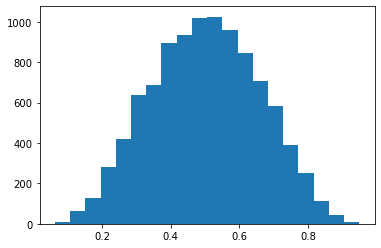

In [340]:
coef = np.array([-0.1, .05, .2, -.05])

exp = expit_transform(coef, variables)
plt.hist(exp, bins=20);

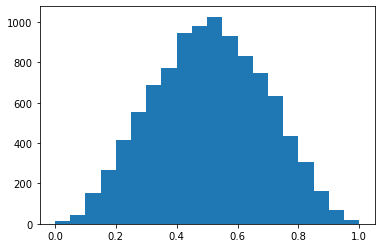

In [311]:

exp2 = (exp - exp.min()) / (exp.max() - exp.min())


plt.hist(exp2, bins=20);

## Treatment assigment

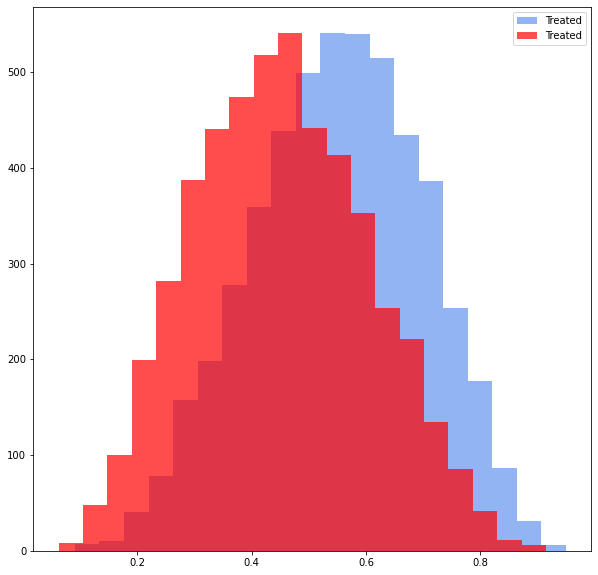

In [341]:



t = treatment_assigment(exp)

fig = plt.figure(figsize=(10, 10))

plt.hist(exp[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

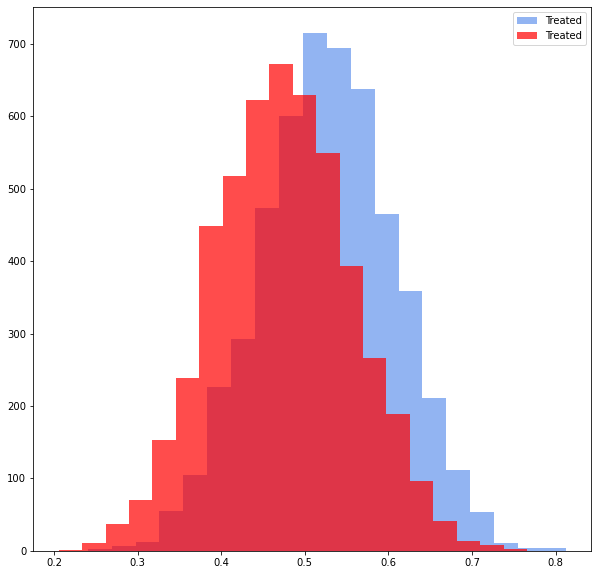

In [460]:
fig = plt.figure(figsize=(10, 10))

plt.hist(exp2[t == 1], bins=20, color='cornflowerblue', alpha=0.7, label= 'Treated');
plt.hist(exp2[t == 0], bins=20, color='red', alpha=0.7, label= 'Treated');

plt.legend();

# Outcome model

In [360]:
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

potential_outcomes_lst = utils.get_potential_outcomes(variables, y_coef, noise)

y = np.where(t == 1, potential_outcomes_lst[1], potential_outcomes_lst[0])


In [361]:
ate = (potential_outcomes_lst[1]  - potential_outcomes_lst[0]).mean()
ate_hat = utils.calc_ipw(y, t, exp)

In [362]:
ate - ate_hat

0.49038657385055195

In [363]:
ate_hat / ate

0.9019226852298896

# Calibration Calculation

In [314]:

err_s = pd.Series(err)
brier_score = brier_score_loss(t, exp)
brier = pd.Series(brier_score, index=['brier'])

calib_res_df = err_s.describe(percentiles=[.1, .5, .9]).append(brier).to_frame().T



In [364]:
ate_hat = utils.calc_ipw(y, t, exp)
utils.generate_calib_error_df(t, exp).assign(ATE=ate_hat)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.019038,0.009125,0.000021,0.005447,0.020683,0.029102,0.052205,0.225334,4.509613


In [442]:
ate_hat2 = utils.calc_ipw(y, t, exp2)
utils.generate_calib_error_df(t, exp2).assign(ATE=ate_hat2)

,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.078785,0.047615,0.000023,0.015811,0.076313,0.141438,0.278149,0.230624,5.368893


In [433]:
pd.Series(exp2).describe()

count    10000.000000
mean         0.501465
std          0.108217
min          0.147051
25%          0.426389
50%          0.501699
75%          0.576626
max          0.870538
dtype: float64

## to check calibration methods

In [466]:
# exp2 = expit(exp ** 2)

from scipy.special import logit
from scipy.stats import norm

exp2 = min_max_transform(logit(exp))

exp2 = min_max_transform(np.arctan(logit(exp)))

exp2 = min_max_transform(np.tanh(logit(exp)))

exp2 = utils.expit_transform(coef, variables, exp_scale=0.5)

exp2 = utils.expit_transform(coef, variables, exp_scale=5)


In [467]:
norm.ppf(logit(exp))

array([        nan,         nan, -0.05542964, ...,         nan,
               nan,  0.05772639])

In [477]:
exp2 = norm.cdf(logit(exp)*2)

In [ ]:
expirments = {
    'identity': lambda x: x
    'min_max': lambda x: min_max_transform(logit(x)),
    'min_max_arctan': lambda x: min_max_transform(np.arctan(logit(exp))),
    'min_max_tanh': lambda x: min_max_transform(np.tanh(logit(exp))),
    'scaled_expit_0.5': lambda x: expit(logit(exp)*0.5),
    'scaled_expit_5': lambda x: expit(logit(exp)*5),
    'probit': lambda x: norm.cdf(logit(exp)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(exp) * 2)
}

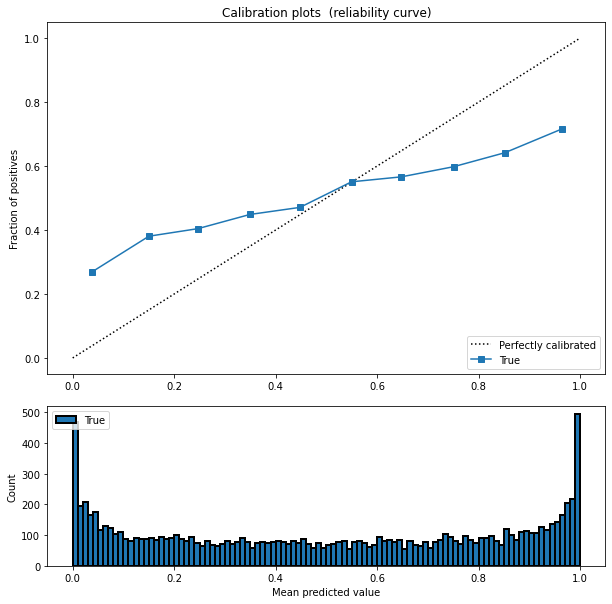

In [478]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")


fraction_of_positives, mean_predicted_value = \
    calibration_curve(t, exp2, n_bins=10)

name = "True"

ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
         label=f"{name}")

ax2.hist(exp2, range=(0, 1), bins=100, label=name, histtype="bar", lw=2, alpha=1, fc=None, edgecolor='black')

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Calibration plots  (reliability curve)')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper left", ncol=2)

In [193]:
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant

In [197]:
lr = Logit(t, add_constant(exp))

In [198]:
res = lr.fit()

Optimization terminated successfully.
         Current function value: 0.638424
         Iterations 5


In [199]:
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.079      
Dependent Variable: y                AIC:              12772.4852 
Date:               2021-06-16 09:45 BIC:              12786.9059 
No. Observations:   10000            Log-Likelihood:   -6384.2    
Df Model:           1                LL-Null:          -6931.0    
Df Residuals:       9998             LLR p-value:      8.7230e-240
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
-------------------------------------------------------------------
            Coef.    Std.Err.     z      P>|z|    [0.025    0.975] 
-------------------------------------------------------------------
const      -11.6532    0.3776  -30.8646  0.0000  -12.3932  -10.9132
x1          18.7691    0.6060   30.9710  0.0000   17.5813   19.9568
==================================================================

"""

# full simulation

In [282]:
amount_of_vars = 4
intercept = 0
mean = 0
std = 1
n = 10000

noise_mean = 1
noise_std = 0

coef = np.array([-0.1, .05, .2, -.05])
y_coef = np.array([5, 1.2, 3.6, 1.2, 1.2, .0])

num_of_experiments = 100

calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments)

# calib_df['type'] = 'true_prop'
calib_df

100%|██████████| 100/100 [06:18<00:00,  3.78s/it]


,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.016686,0.008724,4.452805e-06,0.004833,0.017173,0.025914,0.058126,0.225903,4.947042
1,10000.0,0.017985,0.015709,7.547827e-07,0.002085,0.013021,0.043631,0.075225,0.223897,5.068540
2,10000.0,0.020384,0.009109,1.774839e-06,0.005848,0.023666,0.028599,0.039182,0.224454,4.789406
3,10000.0,0.022423,0.012535,1.935010e-05,0.005615,0.022168,0.039306,0.071857,0.223094,4.875070
4,10000.0,0.012589,0.010087,2.890914e-06,0.003462,0.008132,0.028061,0.056524,0.226321,5.150196
...,...,...,...,...,...,...,...,...,...,...
95,10000.0,0.020454,0.009077,2.414532e-06,0.006086,0.023151,0.029956,0.041871,0.224607,5.259418
96,10000.0,0.012910,0.007753,2.142740e-06,0.003291,0.012386,0.022493,0.039996,0.226406,5.181457
97,10000.0,0.024515,0.015725,5.851388e-06,0.005144,0.026079,0.046119,0.089922,0.222854,5.113116
98,10000.0,0.024924,0.012762,1.321493e-05,0.006269,0.026324,0.041128,0.053425,0.222824,5.036756


In [483]:
expirments = {
    'identity': lambda x: x,
    'min_max': lambda x: min_max_transform(logit(x)),
    'min_max_arctan': lambda x: min_max_transform(np.arctan(logit(x))),
    'min_max_tanh': lambda x: min_max_transform(np.tanh(logit(x))),
    'scaled_expit_0.5': lambda x: expit(logit(x)*0.5),
    'scaled_expit_5': lambda x: expit(logit(x)*5),
    'probit': lambda x: norm.cdf(logit(x)),
    'scaled_probit_0.5': lambda x: norm.cdf(logit(x) * 2)
}

num_of_experiments = 10


calib_df = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, experiments=expirments)

# calib_df['type'] = 'true_prop'
calib_df

100%|██████████| 10/10 [04:58<00:00, 29.86s/it]


,count,mean,std,min,10%,50%,90%,max,brier,type,ATE
0,10000.0,0.017592,0.010052,1.034629e-05,0.005424,0.013638,0.030995,0.031278,0.225836,identity,5.298871
0,10000.0,0.037248,0.019514,3.651573e-06,0.010456,0.035554,0.064600,0.067636,0.226408,min_max,5.558454
0,10000.0,0.042609,0.025858,6.286795e-07,0.008737,0.041400,0.077685,0.113483,0.230815,min_max_arctan,4.359146
0,10000.0,0.076218,0.043313,7.828786e-06,0.015968,0.076763,0.134405,0.168471,0.237943,min_max_tanh,2.845422
0,10000.0,0.077426,0.046167,7.210562e-07,0.016477,0.075248,0.140561,0.236810,0.230809,scaled_expit_0.5,6.092696
...,...,...,...,...,...,...,...,...,...,...,...
9,10000.0,0.072012,0.038097,2.021944e-05,0.016372,0.074890,0.121673,0.146772,0.235333,min_max_tanh,2.945169
9,10000.0,0.081015,0.050864,1.589878e-05,0.016152,0.076766,0.151047,0.274698,0.230012,scaled_expit_0.5,6.155836
9,10000.0,0.191953,0.071414,2.209576e-04,0.075507,0.221098,0.256576,0.261410,0.281276,scaled_expit_5,-264.806278
9,10000.0,0.042656,0.026152,2.972898e-07,0.007383,0.041623,0.078956,0.108247,0.229404,probit,3.960627


In [517]:
calib_df.query('type == "scaled_expit_5"')

,count,mean,std,min,10%,50%,90%,max,brier,type,ATE,ATE_error
0,10000.0,0.194477,0.075106,0.000073,0.070260,0.225023,0.265685,0.270389,0.283848,scaled_expit_5,-413.087607,418.087607
1,10000.0,0.201402,0.073744,0.000056,0.080617,0.232551,0.268195,0.272265,0.286646,scaled_expit_5,-171.013752,176.013752
2,10000.0,0.196842,0.075871,0.000015,0.070245,0.227283,0.266795,0.271604,0.284960,scaled_expit_5,-391.655082,396.655082
3,10000.0,0.197866,0.074981,0.000010,0.074762,0.229471,0.267131,0.271368,0.284653,scaled_expit_5,-366.028031,371.028031
4,10000.0,0.192728,0.071613,0.000101,0.075268,0.222576,0.262107,0.267019,0.281339,scaled_expit_5,-1087.016809,1092.016809
5,10000.0,0.198233,0.074525,0.000035,0.076724,0.228474,0.267293,0.272516,0.285135,scaled_expit_5,-168.649317,173.649317
6,10000.0,0.192621,0.074115,0.000008,0.071426,0.222059,0.267983,0.274238,0.282551,scaled_expit_5,-272.959977,277.959977
7,10000.0,0.190532,0.068589,0.000003,0.078018,0.219754,0.251137,0.254348,0.279506,scaled_expit_5,-78.473519,83.473519
8,10000.0,0.187153,0.069705,0.000048,0.073820,0.215403,0.254002,0.258185,0.278605,scaled_expit_5,-242.673732,247.673732
9,10000.0,0.191953,0.071414,0.000221,0.075507,0.221098,0.256576,0.261410,0.281276,scaled_expit_5,-264.806278,269.806278


In [493]:
calib_df['ATE_error'] = (calib_df['ATE'] - y_coef[0]).pipe(lambda x: np.sqrt(x ** 2))

In [487]:
calib_df.plot.scatter(x='brier', y='ATE_error', figsize=(10,10))


(-0.01, 5.0)

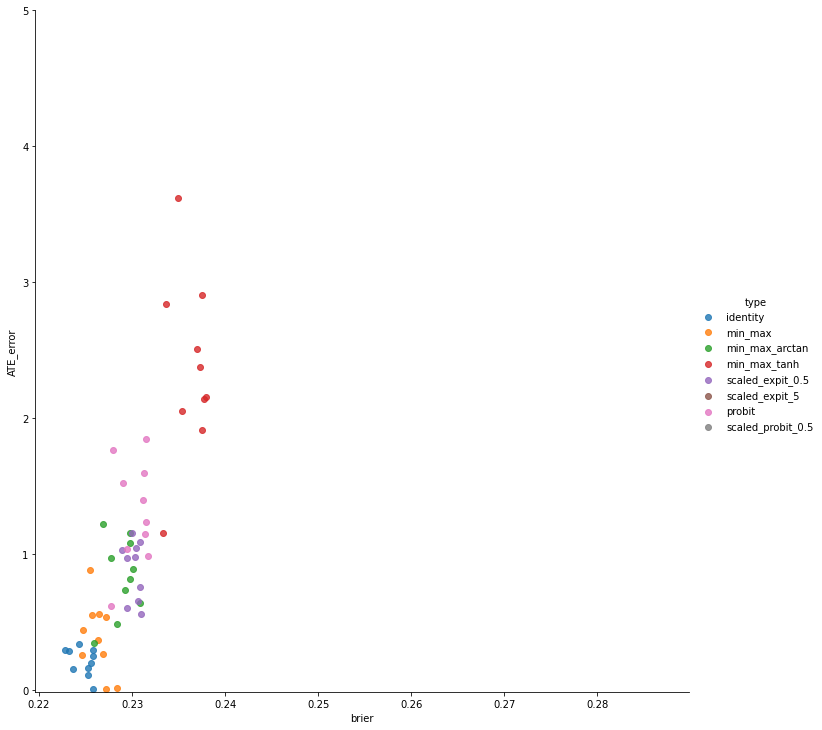

In [504]:
# plt.figure(figsize=(10,10))
sns.lmplot(x='brier', y='ATE_error', data=calib_df, hue='type', fit_reg=False, height=10, aspect=1, scatter=True)

plt.ylim(-0.01, 5)

# plt.legend()

Text(0, 0.5, 'ATE Error')

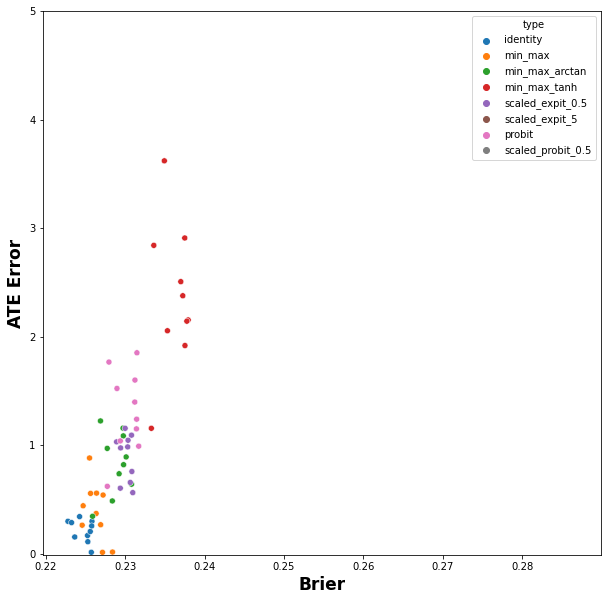

In [513]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='brier', y='ATE_error', data=calib_df, hue='type')
plt.ylim(-0.01, 5)

plt.xlabel('Brier', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})


Text(0, 0.5, 'ATE Error')

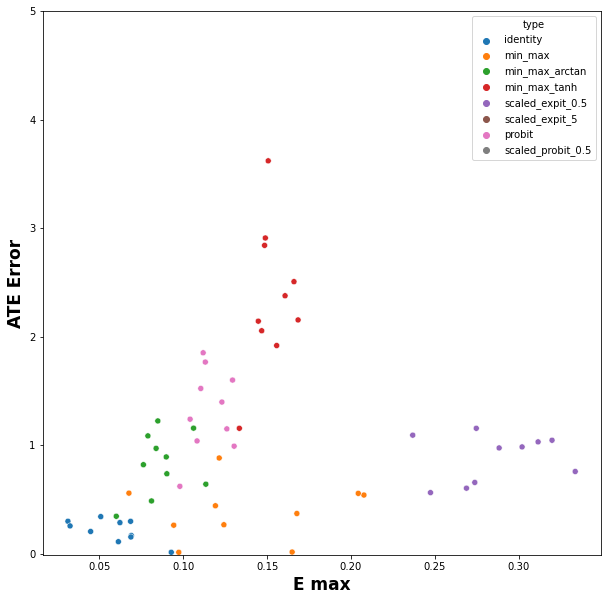

In [515]:
plt.figure(figsize=(10,10))
sns.scatterplot(x='max', y='ATE_error', data=calib_df, hue='type')
plt.ylim(-0.01, 5)


plt.xlabel('E max', fontdict={'weight': 'bold', 'size':17})
plt.ylabel('ATE Error', fontdict={'weight': 'bold', 'size':17})


In [326]:
def min_max_transform(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

calib_df_min_max = utils.generate_simulation(m=amount_of_vars, mean=mean, std=std, n=n, noise_mean=noise_mean,
                                     noise_std=noise_std, coef=coef, y_coef=y_coef, num_of_experiments=num_of_experiments, prop_func=min_max_transform)

calib_df_min_max['type'] = 'min_max'
calib_df_min_max

100%|██████████| 100/100 [06:21<00:00,  3.81s/it]


,count,mean,std,min,10%,50%,90%,max,brier,ATE
0,10000.0,0.007169,0.007015,1.599103e-06,0.001566,0.004726,0.017724,0.043717,0.225639,4.467960
1,10000.0,0.006022,0.005233,8.987875e-07,0.000831,0.003135,0.013660,0.023615,0.225555,5.003496
2,10000.0,0.020164,0.008352,1.067833e-05,0.005727,0.023684,0.027738,0.040211,0.223200,4.577017
3,10000.0,0.015027,0.009676,1.638426e-03,0.002397,0.014672,0.028179,0.034149,0.222593,4.980606
4,10000.0,0.004855,0.004112,1.769438e-06,0.001512,0.004029,0.010134,0.029789,0.225033,-20047.416128
...,...,...,...,...,...,...,...,...,...,...
95,10000.0,0.004993,0.003806,9.376297e-07,0.000846,0.003973,0.010508,0.032536,0.224681,4.701124
96,10000.0,0.012173,0.006196,6.448165e-07,0.004817,0.012120,0.019435,0.049328,0.226774,4.213132
97,10000.0,0.012093,0.004361,1.022760e-05,0.004477,0.014258,0.016088,0.016408,0.220701,4.874188
98,10000.0,0.013602,0.006965,3.675677e-05,0.006198,0.011822,0.024093,0.024865,0.224073,4.576941


In [337]:
calibs = pd.concat([calib_df, calib_df_min_max])

In [338]:
np.mean(np.sqrt((calib_df['ATE'] - y_coef[0]) ** 2))

0.23783713911946053